In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

from IPython.display import display
from pylab import rcParams
from datetime import  datetime, timedelta
from pandas.tseries.offsets import BDay
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../b. Datasets/Shaampoo Sales/Shampoo Sales.csv')

In [3]:
data.shape

(36, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,36.0,312.6,148.937164,119.3,192.45,280.15,411.1,682.0


In [6]:
display(data.head(2))
display(data.tail(2))

,Month,Sales
0,1-01,266.0
1,1-02,145.9


,Month,Sales
34,3-11,581.3
35,3-12,646.9


In [7]:
data.isna().sum()

Month    0
Sales    0
dtype: int64

In [8]:
date_vals = pd.date_range(start='01-01-2001', end='12-01-2003', freq='MS')
date_vals

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01',
               '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [9]:
data.set_index(keys=date_vals, inplace=True)
data.drop(labels='Month', axis=1, inplace=True)
display(data.head(2))

,Sales
2001-01-01,266.0
2001-02-01,145.9


In [10]:
data.isna().sum()

Sales    0
dtype: int64

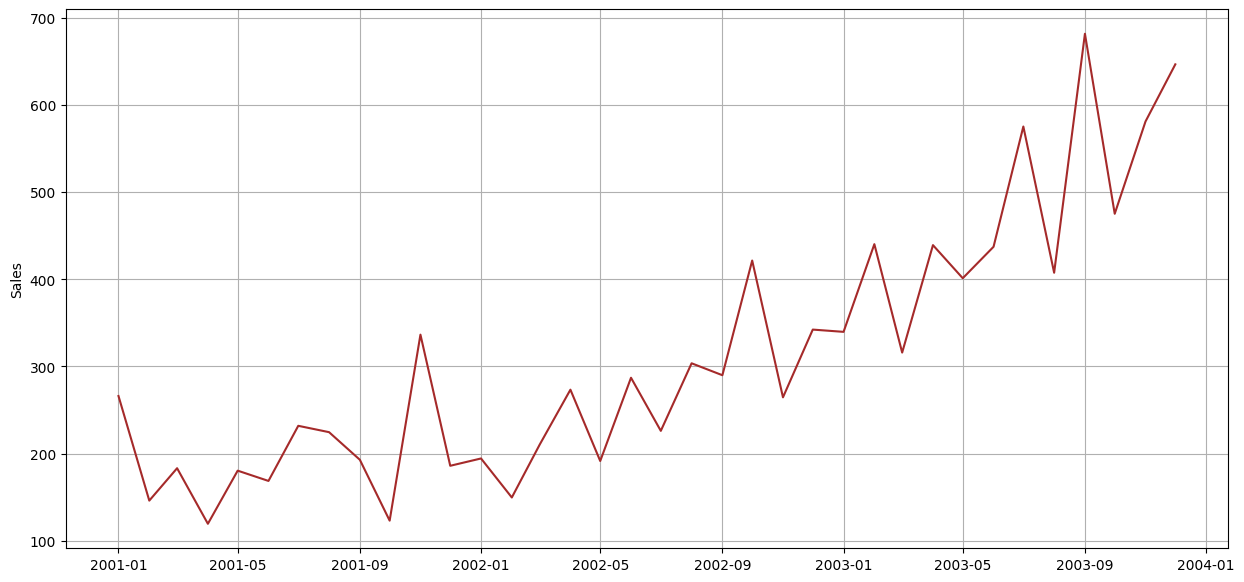

In [11]:
plt.figure(figsize=(15, 7))
sns.lineplot(data['Sales'], color='brown')
plt.grid()
plt.show()

<Axes: xlabel='None', ylabel='Sales'>

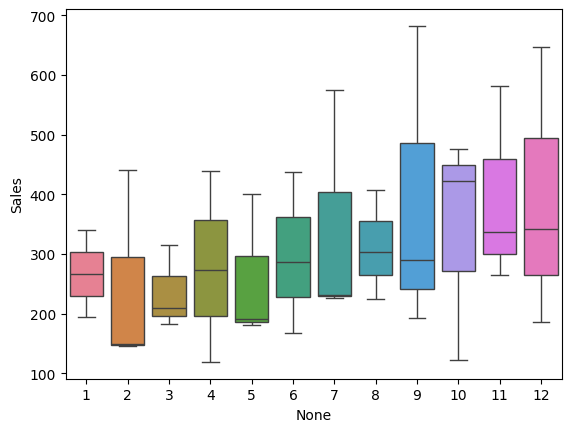

In [12]:
sns.boxplot(x=data.index.month, y=data['Sales'], palette='husl')

<Axes: xlabel='None', ylabel='Sales'>

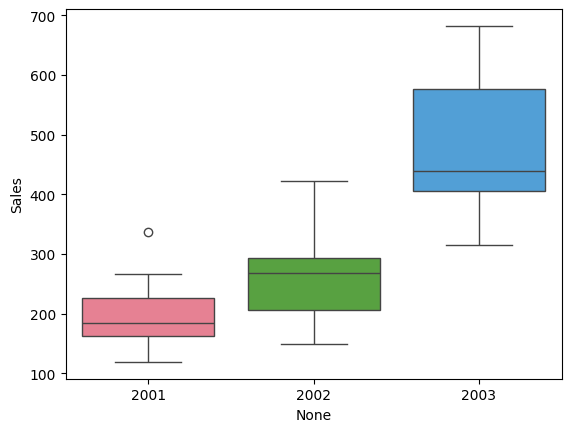

In [13]:
sns.boxplot(x=data.index.year, y=data['Sales'], palette='husl')

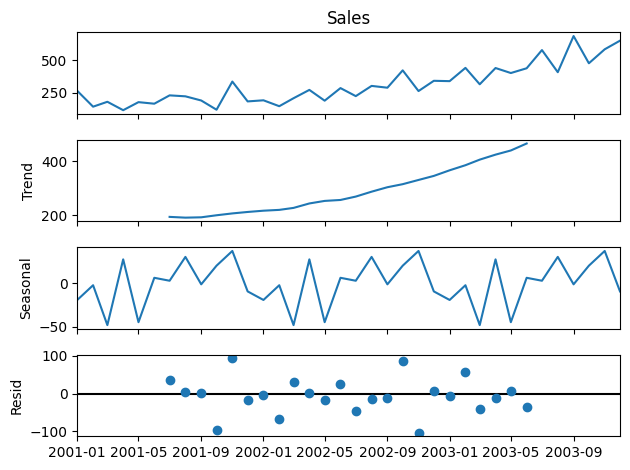

In [14]:
seasonal_decompose(data['Sales'], model='additive').plot();

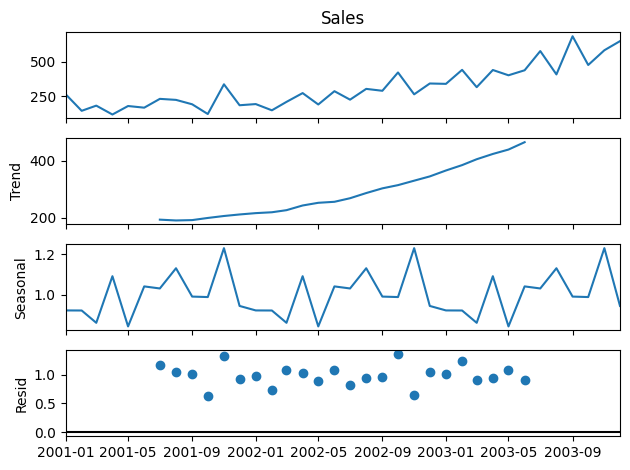

In [15]:
seasonal_decompose(data['Sales'], model='multiplicative').plot();

In [16]:
adf_stat = adfuller(data['Sales'])
alpha = 0.05
p_value = adf_stat[1]
if p_value < alpha:
    print("Rejecting null hypothesis. The dataset is stationary. P value:", p_value)
else:
    print("The null hypothesis cannot be rejected. The dataset is not stationary. P value:", p_value)

The null hypothesis cannot be rejected. The dataset is not stationary. P value: 1.0


In [17]:
data_1diff = data.diff(periods=1).dropna()

In [18]:
adf_stat = adfuller(data_1diff)
p_value = adf_stat[1]
alpha = 0.05

if p_value < alpha:
    print("Rejecting null hypothesis. The dataset is stationary. p value:", p_value)
else:
    print("The null hypothesis cannot be rejected. The dataset is not stationary. p  value:", p_value)

Rejecting null hypothesis. The dataset is stationary. p value: 1.7998574141687034e-10


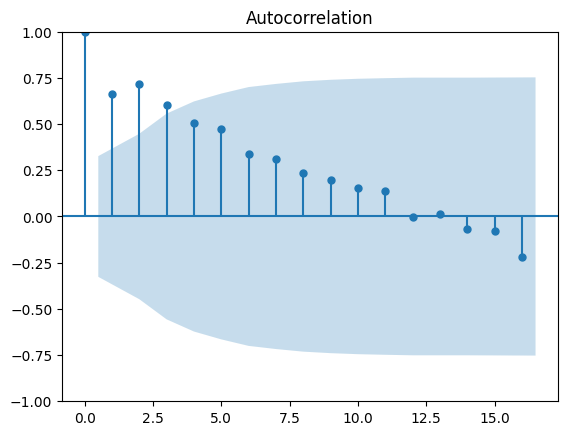

In [19]:
plot_acf(data);

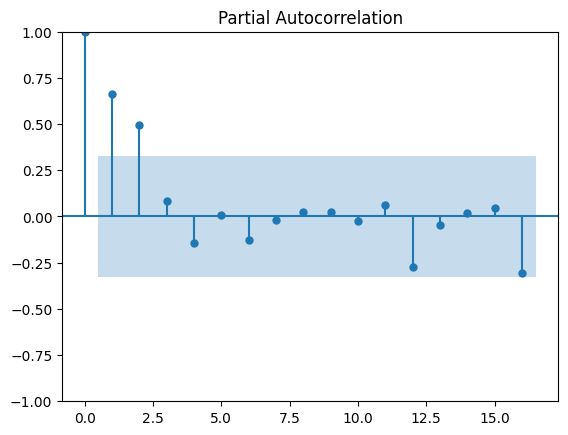

In [20]:
plot_pacf(data);

- ACF Plot: The gradual decay suggests the presence of an autoregressive (AR) component rather than a moving average (MA) process. In an MA(q) process, we would expect a sharp cutoff after q lags.
- PACF Plot: The significant spikes at lags 1 and 2, followed by a drop-off, indicate an AR(2) process.

## Divide the data in 70:30 in train and test Use test data for testing. (3 marks) 

In [21]:
len(data) * 0.7

25.2

In [22]:
train_data = data[:25]
test_data = data[25:]

In [23]:
train_data.shape

(25, 1)

In [24]:
display(train_data.head(2))
display(train_data.tail(2))

,Sales
2001-01-01,266.0
2001-02-01,145.9


,Sales
2002-12-01,342.3
2003-01-01,339.7


In [25]:
test_data.shape

(11, 1)

In [26]:
display(test_data.head(2))
display(test_data.tail(2))

,Sales
2003-02-01,440.4
2003-03-01,315.9


,Sales
2003-11-01,581.3
2003-12-01,646.9


## Fit ARIMA model and observe the RMSE and MAPE values of the model for test data. 

In [27]:
p = q = range(0, 4)
d = range(0, 2)

pdq = list(itertools.product(p, d, q))

aic_df = []

for order in pdq:
    arima_model = ARIMA(train_data, order=order, 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)
    result_arima = arima_model.fit()
    aic_df.append((order, result_arima.aic))
    print(f'Calculation complete for order {order}. AIC: {result_arima.aic}')

Calculation complete for order (0, 0, 0). AIC: 280.24039071749417
Calculation complete for order (0, 0, 1). AIC: 269.06604527925697
Calculation complete for order (0, 0, 2). AIC: 257.5551145457681
Calculation complete for order (0, 0, 3). AIC: 247.04719916751083
Calculation complete for order (0, 1, 0). AIC: 272.31529260207736
Calculation complete for order (0, 1, 1). AIC: 250.94769645913692
Calculation complete for order (0, 1, 2). AIC: 237.19626894760094
Calculation complete for order (0, 1, 3). AIC: 228.1965502978813
Calculation complete for order (1, 0, 0). AIC: 279.76939255529857
Calculation complete for order (1, 0, 1). AIC: 259.67211106374634
Calculation complete for order (1, 0, 2). AIC: 249.47596593123632
Calculation complete for order (1, 0, 3). AIC: 239.89504717962586
Calculation complete for order (1, 1, 0). AIC: 261.23351446475306
Calculation complete for order (1, 1, 1). AIC: 250.49117064688068
Calculation complete for order (1, 1, 2). AIC: 241.67695959180585
Calculation 

In [28]:
aic_df = pd.DataFrame(data=aic_df, columns=['Order', 'AIC'])
aic_df.sort_values(by='AIC', ascending=True, inplace=True)
aic_df.head(2)

,Order,AIC
7,"(0, 1, 3)",228.196550
15,"(1, 1, 3)",230.186151


In [29]:
arima_model = ARIMA(train_data, order=aic_df.iloc[0]['Order'], 
                    enforce_invertibility=False, 
                    enforce_stationarity=False)
result_arima = arima_model.fit()
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   25
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -110.098
Date:                Thu, 13 Mar 2025   AIC                            228.197
Time:                        21:55:23   BIC                            232.179
Sample:                    01-01-2001   HQIC                           228.974
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1926      0.375     -3.184      0.001      -1.927      -0.459
ma.L2          0.6586      0.614      1.073      0.283      -0.544       1.861
ma.L3          0.2385      0.349      0.684      0.494      -0.445       0.922
sigma2      2906.9431      0.000   1.18e+07      0.000    2906.943    2906.944
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.81   Prob(JB):                         0.91
Heteroskedasticity (H):               0.53   Skew:                            -0.12
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+23. Standard errors may be unstable.
"""

In [30]:
arima_test_pred = result_arima.forecast(len(test_data))

In [31]:
from sklearn.metrics import *

In [32]:
mean_squared_error(test_data['Sales'].values, arima_test_pred, squared=False)

196.4249512792009

In [33]:
mean_absolute_percentage_error(test_data['Sales'].values, arima_test_pred)

0.30484590730436284

<Axes: ylabel='Sales'>

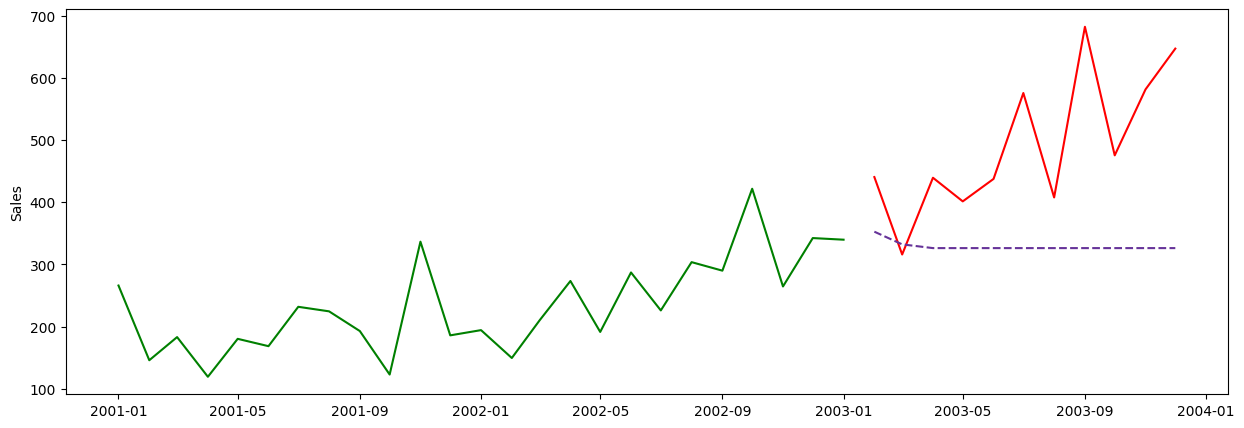

In [34]:
plt.figure(figsize=(15, 5))
sns.lineplot(train_data['Sales'], color='green')
sns.lineplot(test_data['Sales'], color='red')
sns.lineplot(arima_test_pred, color='rebeccapurple', linestyle='--')

### Fit exponential smoothing model and observe the residuals, RMSE and MAPE values of the model for test data. 

### SINGLE Exponential Smoothing

In [35]:
ses_model = ExponentialSmoothing(train_data, 
                                 initialization_method='estimated')

In [36]:
result_ses = ses_model.fit()
result_ses.summary()

Dep. Variable:,Sales,No. Observations:,25
Model:,ExponentialSmoothing,SSE,106498.768
Optimized:,True,AIC,212.925
Trend:,None,BIC,215.363
Seasonal:,None,AICC,214.925
Seasonal Periods:,None,Date:,"Thu, 13 Mar 2025"
Box-Cox:,False,Time:,21:55:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2955315,alpha,True
initial_level,196.35095,l.0,True


In [37]:
ses_forecast = result_ses.forecast(len(test_data))

In [38]:
mean_squared_error(test_data['Sales'].values, ses_forecast, squared=False)

203.706472017809

In [39]:
mean_absolute_percentage_error(test_data['Sales'].values, ses_forecast)

0.3198796258835213

## DOUBLE Exponential Smoothing

In [40]:
des_model = ExponentialSmoothing(train_data, trend='multiplicative', seasonal=None, initialization_method='estimated')

In [41]:
result_des = des_model.fit()
result_des.summary()

Dep. Variable:,Sales,No. Observations:,25
Model:,ExponentialSmoothing,SSE,76395.092
Optimized:,True,AIC,208.620
Trend:,Multiplicative,BIC,213.495
Seasonal:,None,AICC,213.287
Seasonal Periods:,None,Date:,"Thu, 13 Mar 2025"
Box-Cox:,False,Time:,21:55:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,9.8873e-09,beta,True


In [42]:
des_forecast = result_des.forecast(len(test_data))

In [43]:
mean_squared_error(test_data['Sales'].values, des_forecast, squared=False)

122.39678560316104

In [44]:
mean_absolute_percentage_error(test_data['Sales'].values, des_forecast)

0.17703492006627294

<Axes: ylabel='Sales'>

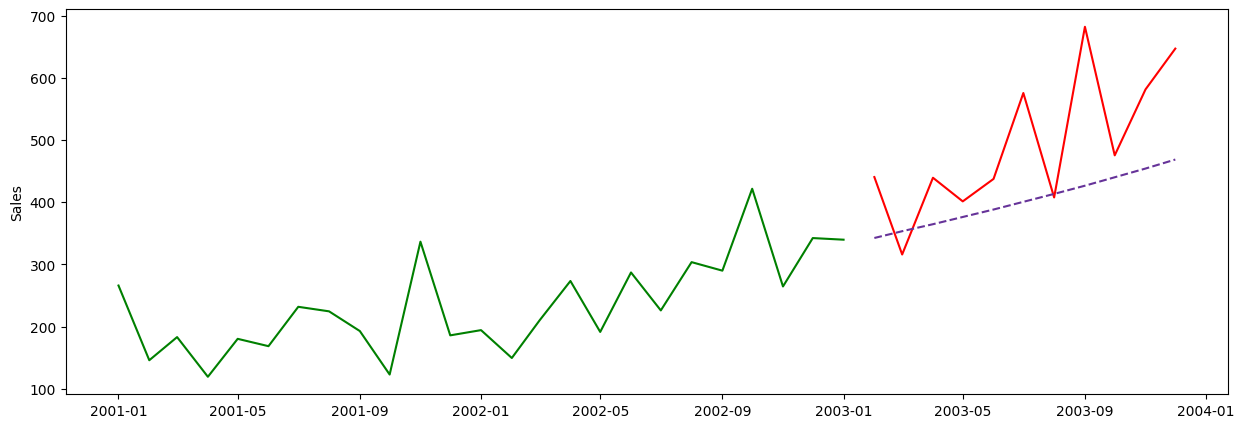

In [45]:
plt.figure(figsize=(15, 5))
sns.lineplot(train_data['Sales'], color='green')
sns.lineplot(test_data['Sales'], color='red')
sns.lineplot(des_forecast, color='rebeccapurple', linestyle='--')

## TRIPLE Exponential Smoothing

In [46]:
tes_model = ExponentialSmoothing(train_data, 
                                 trend='multiplicative', 
                                 seasonal='multiplicative', 
                                 initialization_method='estimated', 
                                 seasonal_periods=12,
                                 use_boxcox=True)

In [47]:
result_tes = tes_model.fit()
result_tes.summary()

Dep. Variable:,Sales,No. Observations:,25
Model:,ExponentialSmoothing,SSE,66306.437
Optimized:,True,AIC,229.079
Trend:,Multiplicative,BIC,248.581
Seasonal:,Multiplicative,AICC,343.079
Seasonal Periods:,12,Date:,"Thu, 13 Mar 2025"
Box-Cox:,True,Time:,21:55:24
Box-Cox Coeff.:,0.10383,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4268e-08,beta,True


In [48]:
tes_forecast = result_tes.forecast(len(test_data))

In [49]:
mean_squared_error(test_data['Sales'].values, tes_forecast, squared=False)

170.87042068442307

In [50]:
mean_absolute_percentage_error(test_data['Sales'].values, tes_forecast)

0.2748747233994367

<Axes: ylabel='Sales'>

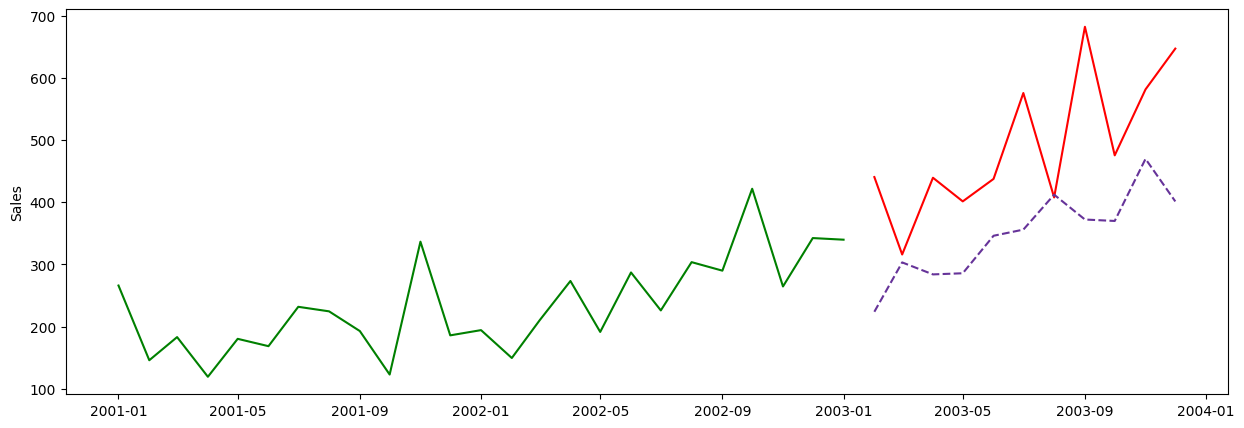

In [51]:
plt.figure(figsize=(15, 5))
sns.lineplot(train_data['Sales'], color='green')
sns.lineplot(test_data['Sales'], color='red')
sns.lineplot(tes_forecast, color='rebeccapurple', linestyle='--')

### Tuning Holt Winters Model

In [52]:
alphas = betas = gammas = np.linspace(0, 1.0, 10)
best_score = float('inf')
best_params = None
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                exp_model = ExponentialSmoothing(train_data, 
                                                 trend='multiplicative', 
                                                 seasonal='multiplicative', 
                                                 initialization_method='estimated')
                result_exp = exp_model.fit(smoothing_level=alpha, 
                                           smoothing_trend=beta, 
                                           smoothing_seasonal=gamma)
                error = np.mean(np.abs(result_exp.resid))
                if error < best_score:
                    best_params = (alpha, beta, gamma)
                    best_score = error
            except:
                print('Value not possible for model.')

In [53]:
best_params

(0.1111111111111111, 0.5555555555555556, 0.0)

In [54]:
exp_model = ExponentialSmoothing(train_data, 
                                 trend='multiplicative', 
                                 seasonal='multiplicative', 
                                 initialization_method='estimated')

In [55]:
result_exp = exp_model.fit(smoothing_level=best_params[0], 
                              smoothing_trend=best_params[1],
                              smoothing_seasonal=best_params[2])

In [56]:
exp_train_forecast = result_exp.predict(start=train_data.index[0], 
                                        end=train_data.index[-1])

In [57]:
print("Train RMSE:", mean_squared_error(train_data['Sales'].values, exp_train_forecast, squared=False))
print("Train MAPE:", mean_absolute_percentage_error(train_data['Sales'].values, exp_train_forecast))

Train RMSE: 51.12394287117999
Train MAPE: 0.16660601194918892


In [58]:
exp_forecast = result_exp.forecast(len(test_data))

In [59]:
print("Test RMSE:", mean_squared_error(test_data['Sales'].values, exp_forecast, squared=False))

Test RMSE: 117.69138904132214


In [60]:
print("Test MAPE:", mean_absolute_percentage_error(test_data['Sales'].values, exp_forecast))

Test MAPE: 0.20139453481413394


<Axes: ylabel='Sales'>

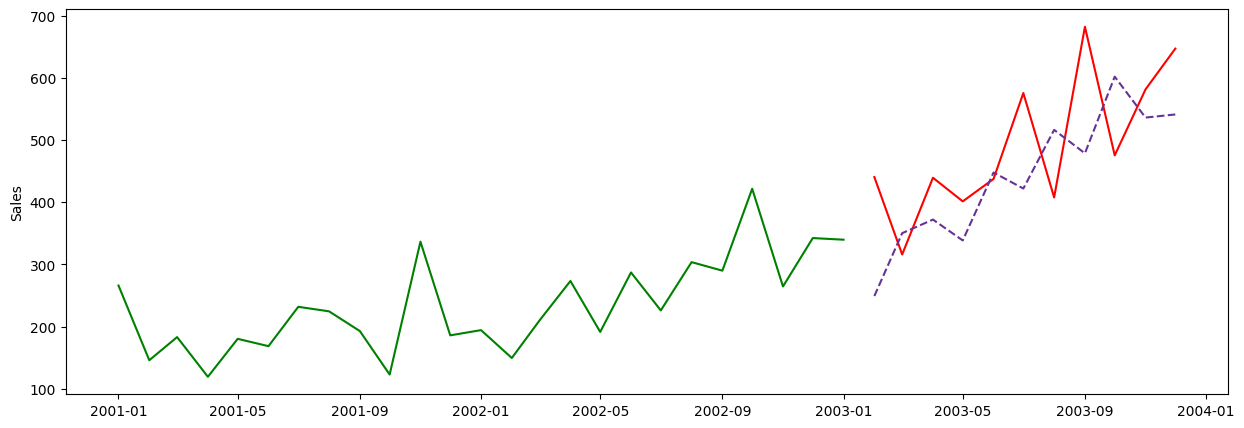

In [61]:
plt.figure(figsize=(15, 5))
sns.lineplot(train_data['Sales'], color='green')
sns.lineplot(test_data['Sales'], color='red')
sns.lineplot(exp_forecast, color='rebeccapurple', linestyle='--')

In [62]:
residuals = test_data['Sales'] - exp_forecast

<Axes: ylabel='Count'>

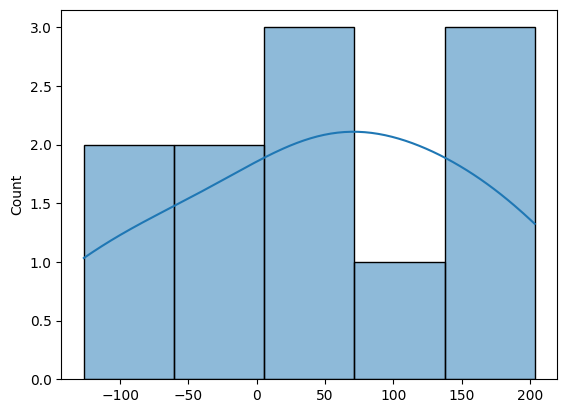

In [63]:
sns.histplot(residuals, kde=True)

In [64]:
residuals.skew()

-0.2257751497387434

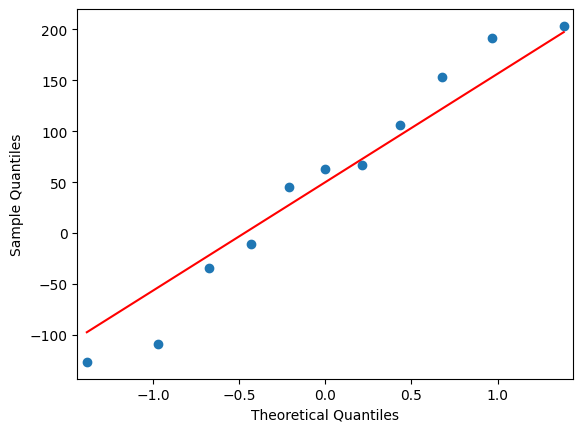

In [65]:
qqplot(residuals, line='s');

## SARIMAX

In [66]:
p = q = range(0, 3)
d = range(1, 2)

pdq = list(itertools.product(p, d, q))
model_pdq = list((p, d, q, 12) for p, d, q in pdq)

In [67]:
aic_df = []
for order in pdq:
    for seasonal_order in model_pdq:
        sarimax_model = sm.tsa.SARIMAX(train_data, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       enforce_invertibility=False, 
                                       enforce_stationarity=False)
        results_sarimax = sarimax_model.fit()
        aic_df.append((order, seasonal_order, results_sarimax.aic))
    print('Complete for order', order)

Complete for order (0, 1, 0)
Complete for order (0, 1, 1)
Complete for order (0, 1, 2)
Complete for order (1, 1, 0)
Complete for order (1, 1, 1)
Complete for order (1, 1, 2)
Complete for order (2, 1, 0)
Complete for order (2, 1, 1)
Complete for order (2, 1, 2)


In [68]:
aic_df = pd.DataFrame(data=aic_df, 
                      columns=['Order', 'Seasonal Order', "AIC"]).sort_values(by='AIC', 
                                                                              ascending=True)
aic_df

,Order,Seasonal Order,AIC
1,"(0, 1, 0)","(0, 1, 1, 12)",4.000000
3,"(0, 1, 0)","(1, 1, 0, 12)",4.000000
2,"(0, 1, 0)","(0, 1, 2, 12)",6.000000
4,"(0, 1, 0)","(1, 1, 1, 12)",6.000000
6,"(0, 1, 0)","(2, 1, 0, 12)",6.000000
...,...,...,...
36,"(1, 1, 1)","(0, 1, 0, 12)",128.409124
54,"(2, 1, 0)","(0, 1, 0, 12)",129.831176
63,"(2, 1, 1)","(0, 1, 0, 12)",130.332329
27,"(1, 1, 0)","(0, 1, 0, 12)",140.606769


In [69]:
sarimax_model = sm.tsa.SARIMAX(train_data, 
                               order=aic_df.iloc[0]['Order'], 
                               seasonal_order=aic_df.iloc[0]['Seasonal Order'], 
                               enforce_invertibility=False, 
                               enforce_stationarity=False)

In [70]:
results_sarimax = sarimax_model.fit()

In [71]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                   0.000
Date:                              Thu, 13 Mar 2025   AIC                              4.000
Time:                                      21:56:34   BIC                                nan
Sample:                                  01-01-2001   HQIC                               nan
                                       - 01-01-2003                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12            0         -0        nan        nan           0           0
sigma2      2.336e+04         -0       -inf      0.000    2.34e+04    2.34e+04
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [72]:
sarimax_train_forecast = results_sarimax.predict(start=train_data.index[0], 
                                                 end=train_data.index[-1])

In [73]:
print("Train RMSE:", mean_squared_error(train_data['Sales'].values, sarimax_train_forecast, squared=False))
print("Train MAPE:", mean_absolute_percentage_error(train_data['Sales'].values, sarimax_train_forecast))

Train RMSE: 142.6775849404673
Train MAPE: 0.4797679138999094


In [74]:
sarimax_test_forecast = results_sarimax.forecast(len(test_data))

In [75]:
print("Train RMSE:", mean_squared_error(test_data['Sales'].values, sarimax_test_forecast, squared=False))

Train RMSE: 133.04516321364486


In [76]:
print("Test MAPE:", mean_absolute_percentage_error(test_data['Sales'].values, sarimax_test_forecast))

Test MAPE: 0.2024201464139634


<Axes: ylabel='Sales'>

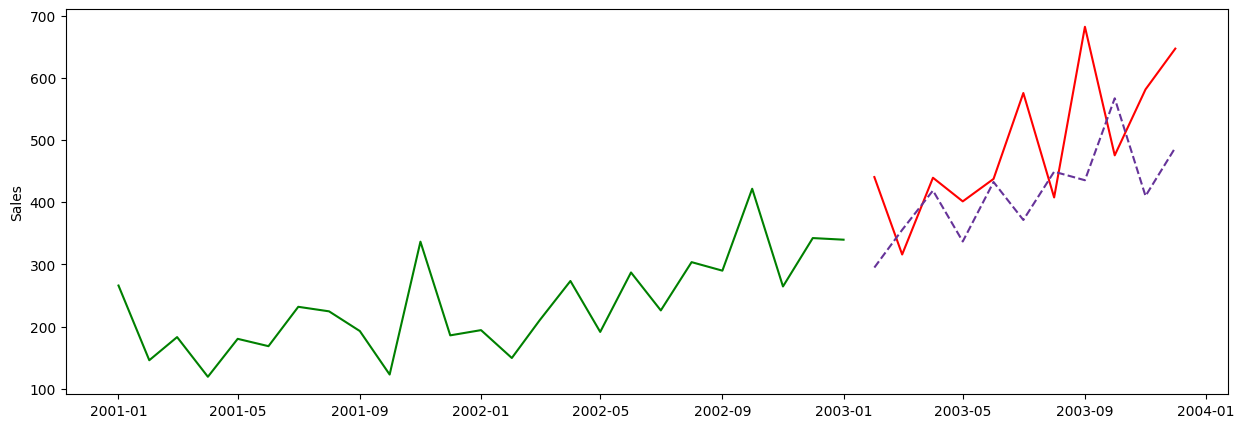

In [77]:
plt.figure(figsize=(15, 5))
sns.lineplot(train_data['Sales'], color='green')
sns.lineplot(test_data['Sales'], color='red')
sns.lineplot(sarimax_test_forecast, color='rebeccapurple', linestyle='--')

## Forecast the Avg Spending price for next 6 months using the final model?

In [78]:
exp_model = ExponentialSmoothing(data['Sales'], 
                                 trend='multiplicative', 
                                 seasonal='multiplicative', 
                                 initialization_method='estimated')

In [79]:
result_exp = exp_model.fit(smoothing_level=best_params[0], 
                              smoothing_trend=best_params[1],
                              smoothing_seasonal=best_params[2])

In [80]:
forecast = result_exp.forecast(6)

<Axes: ylabel='Sales'>

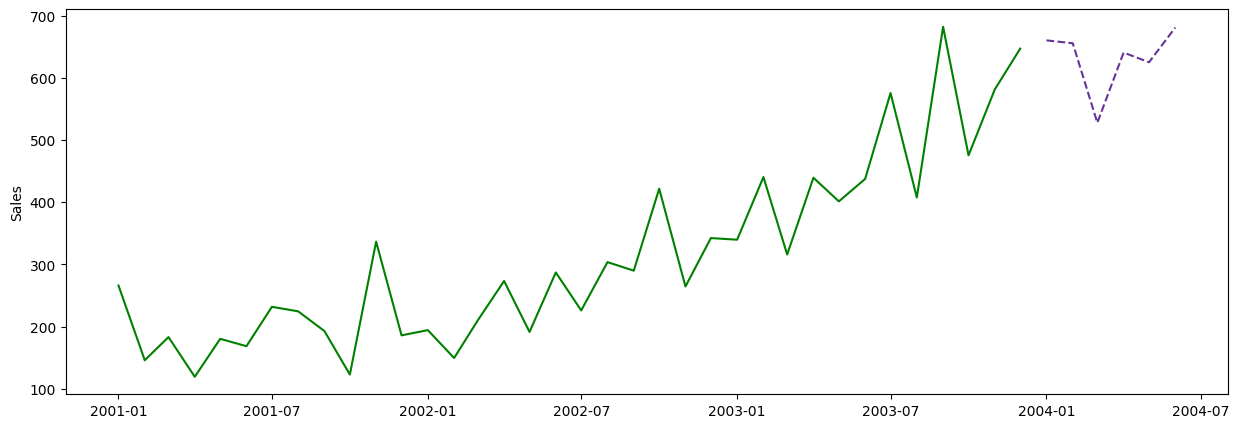

In [81]:
plt.figure(figsize=(15, 5))
sns.lineplot(data['Sales'], color='green')
sns.lineplot(forecast, color='rebeccapurple', linestyle='--')

In [82]:
submission_df = pd.DataFrame(forecast, columns=['Sales'])

In [83]:
display(submission_df.head(2))
display(submission_df.tail(2))

,Sales
2004-01-01,660.152726
2004-02-01,655.477408


,Sales
2004-05-01,624.983912
2004-06-01,680.773481


In [84]:
submission_df.to_csv('../d. Output Files/Shaampoo Sales/Shampoo Sales Forecast.csv', index=True)